# Explain different DL models for Sleep Staging with Spectral Gradients

In [1]:
from loguru import logger

import numpy as np
import torch

from tqdm.notebook import tqdm

from captum.attr import IntegratedGradients, GradientShap

from pytorch_lightning import seed_everything

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import signal
import pandas as pd
import os

import seaborn as sns
from matplotlib import pyplot as plt

torch.backends.cudnn.enabled = False
seed_everything(42)

Seed set to 42


42

In [2]:
from physioex.data import PhysioExDataModule, PhysioExDataset

from physioex.train.networks import config as networks
from physioex.train.networks.utils.loss import config as losses

from physioex.models import load_pretrained_model

from physioex.explain.spectralgradients import (
    SpectralGradients,
    generate_frequency_bands,
    plot,
)


from physioex.explain.spectralgradients.viz import plot_class_spectrum

In [3]:
# dataset
selected_channels = ["EEG"]
n_bands = 50
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
sequence_length = 21

model_name = "chambon2018"
model = load_pretrained_model(
    name=model_name,
    in_channels=len(selected_channels),
    sequence_length=sequence_length,
    softmax=True,
).eval()

/home/guido/github/physioex-private/physioex/models/load.py:55: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ckpt_path = ckpt_path[check_table["sequence_length"] == sequence_length]
/home/guido/github/physioex-private/physioex/models/load.py:56: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ckpt_path = ckpt_path[check_table["in_channels"] == in_channels]
/home/guido/github/physioex-private/physioex/models/load.py:57: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ckpt_path = ckpt_path[check_table["loss"] == loss]


1


In [4]:
# load dataset and model

dataset = PhysioExDataset(
    datasets = ["shhs"],
    preprocessing="raw",
    selected_channels=selected_channels,
    sequence_length=sequence_length,
    target_transform= networks[model_name]["target_transform"],
    data_folder="/mnt/guido-data/"
)


ig = IntegratedGradients(model)
eg = GradientShap(model)

start_freq = 0.0001
sg = SpectralGradients(model, n_bands=n_bands, mode="linear", start_freq=start_freq)
bands = sg.bands


Frequency bands: [[0.0001, 0.98], [0.98, 1.96], [1.96, 2.94], [2.94, 3.92], [3.92, 4.9], [4.9, 5.88], [5.88, 6.86], [6.86, 7.84], [7.84, 8.82], [8.82, 9.8], [9.8, 10.78], [10.78, 11.76], [11.76, 12.74], [12.74, 13.72], [13.72, 14.7], [14.7, 15.68], [15.68, 16.66], [16.66, 17.64], [17.64, 18.62], [18.62, 19.6], [19.6, 20.58], [20.58, 21.56], [21.56, 22.54], [22.54, 23.52], [23.52, 24.5], [24.5, 25.48], [25.48, 26.46], [26.46, 27.44], [27.44, 28.42], [28.42, 29.4], [29.4, 30.38], [30.38, 31.36], [31.36, 32.34], [32.34, 33.32], [33.32, 34.3], [34.3, 35.28], [35.28, 36.26], [36.26, 37.24], [37.24, 38.22], [38.22, 39.2], [39.2, 40.18], [40.18, 41.16], [41.16, 42.14], [42.14, 43.12], [43.12, 44.1], [44.1, 45.08], [45.08, 46.06], [46.06, 47.04], [47.04, 48.02], [48.02, 49.0]]


In [5]:
nrem3 = []
wake = []

wake_probas = []
nrem3_probas = []

with torch.no_grad():
    progress_bar = tqdm(dataset, desc=f"( {len(nrem3)} NREM3, {len(wake)} Wake )")
    
    for i, (x, y) in enumerate(progress_bar):
        # take only the DeepSleep epochs or Wake epochs
        if min(len(nrem3), len(wake)) > 50:
            break
        
        if y != 3 and y != 0:
            continue
        
        # take the corrected classified elements
        # add batch dimension to x
        x = x.unsqueeze(0) 

        probas = model(x.to(device)).detach().cpu()
        label = torch.argmax(probas, dim=1)

        if label == 3:
            nrem3_probas.append(probas)
            nrem3.append(x)
        elif label == 0:
            wake_probas.append(probas)
            wake.append(x)
        
        # Update the description
        progress_bar.set_description(f"( {len(nrem3)} NREM3, {len(wake)} Wake )")
        
wake = torch.cat(wake, dim=0)
nrem3 = torch.cat(nrem3, dim=0)

nrem3_probas = torch.cat(nrem3_probas, dim=0)
wake_probas = torch.cat(wake_probas, dim=0)

print( wake.shape, nrem3.shape)


( 0 NREM3, 0 Wake ):   0%|          | 0/5347946 [00:00<?, ?it/s]

torch.Size([51, 21, 1, 3000]) torch.Size([53, 21, 1, 3000])


In [6]:
def compute_importances_batch(data_loader, label):
    ig_attrs = []
    eg_attrs = []
    sg_attrs = []

    for x in tqdm(data_loader):
        x = x.to(device)
        
        # Integrated Gradients
        ig_attr = ig.attribute(x, target=label, n_steps=20).detach().cpu().numpy()
        ig_attrs.append(ig_attr)

        # Expected Gradients
        # draw 1000 random samples from the dataset for baselines
        baselines = []
        for _ in range(100):
            x_baseline, _ = dataset[np.random.randint(0, len(dataset))]
            baselines.append(x_baseline.unsqueeze(0))
        baselines = torch.cat(baselines, dim=0).to(device)
        
        eg_attr = eg.attribute(x, target=label, n_samples=20, baselines=baselines).detach().cpu().numpy()
        eg_attrs.append(eg_attr)
        del baselines

        # Saliency
        sg_attr = sg.attribute(x, target=label).detach().cpu().numpy()
        sg_attrs.append(sg_attr)

    ig_attrs = np.concatenate(ig_attrs, axis=0)
    eg_attrs = np.concatenate(eg_attrs, axis=0)
    sg_attrs = np.concatenate(sg_attrs, axis=0)

    return ig_attrs, eg_attrs, sg_attrs

from torch.utils.data import DataLoader
# Creare DataLoader per wake e nrem3
wake_loader = DataLoader(wake, batch_size=32, shuffle=False)
nrem3_loader = DataLoader(nrem3, batch_size=32, shuffle=False)

# Calcolare le importanze per tutte le istanze di wake e nrem3
wake_importances = compute_importances_batch(wake_loader, label=0)  # Wake label
nrem3_importances = compute_importances_batch(nrem3_loader, label=3)  # NREM3 label



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

In [7]:
ig_attr, eg_attr, sg_attr = wake_importances
print("Wake IG", ig_attr.shape)
print("Wake EG", eg_attr.shape)
print("Wake SG", sg_attr.shape)

ig_attr, eg_attr, sg_attr = nrem3_importances
print("NREM3 IG", ig_attr.shape)
print("NREM3 EG", eg_attr.shape)
print("NREM3 SG", sg_attr.shape)

Wake IG (51, 21, 1, 3000)
Wake EG (51, 21, 1, 3000)
Wake SG (51, 21, 1, 3000, 50)
NREM3 IG (53, 21, 1, 3000)
NREM3 EG (53, 21, 1, 3000)
NREM3 SG (53, 21, 1, 3000, 50)


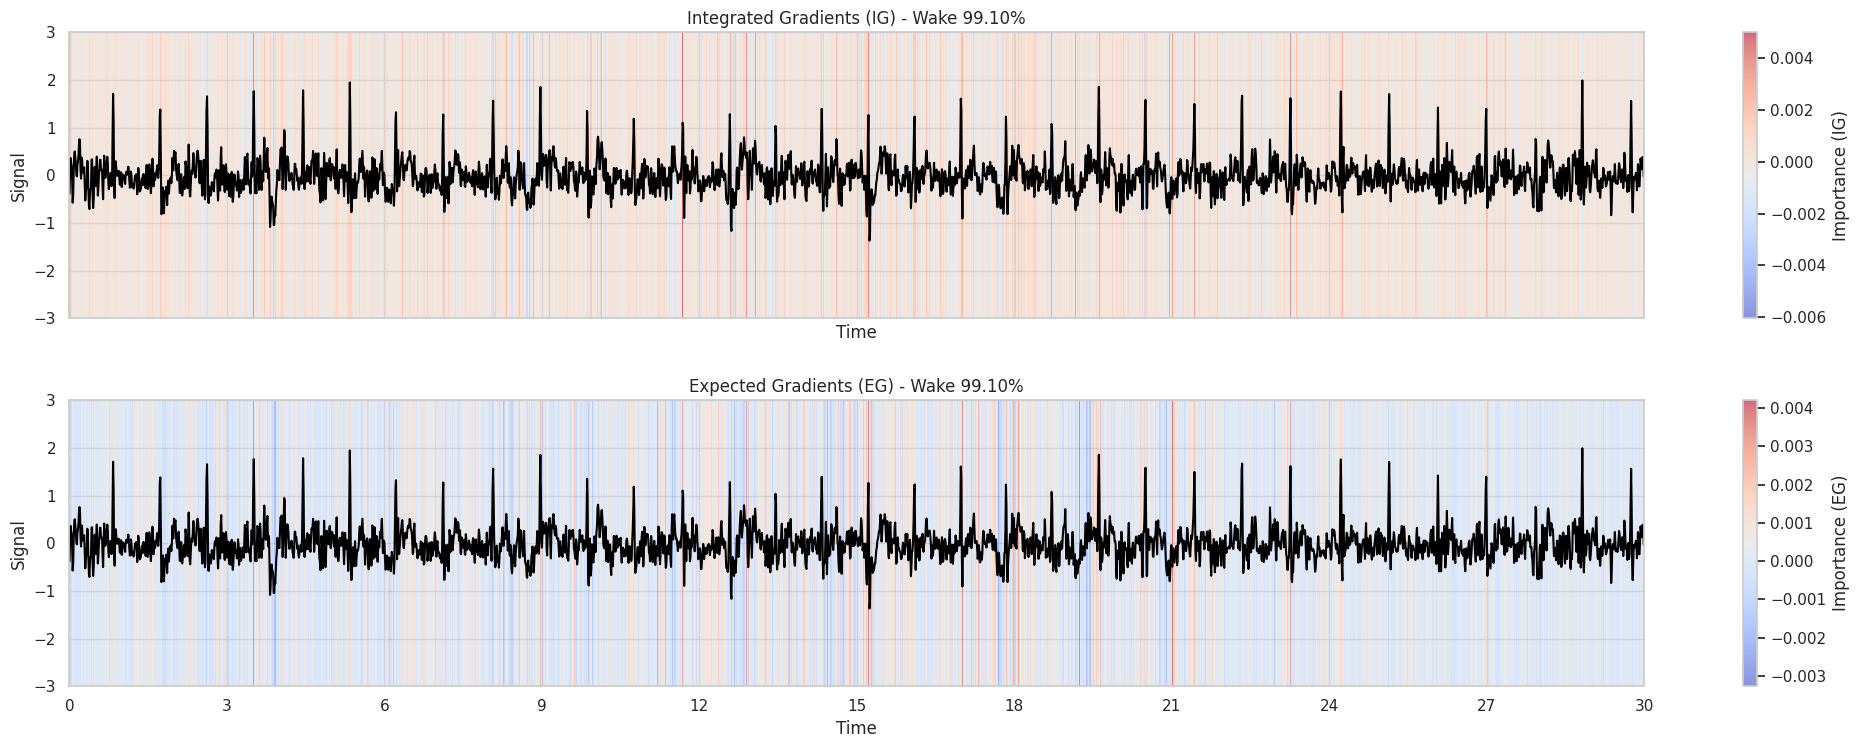

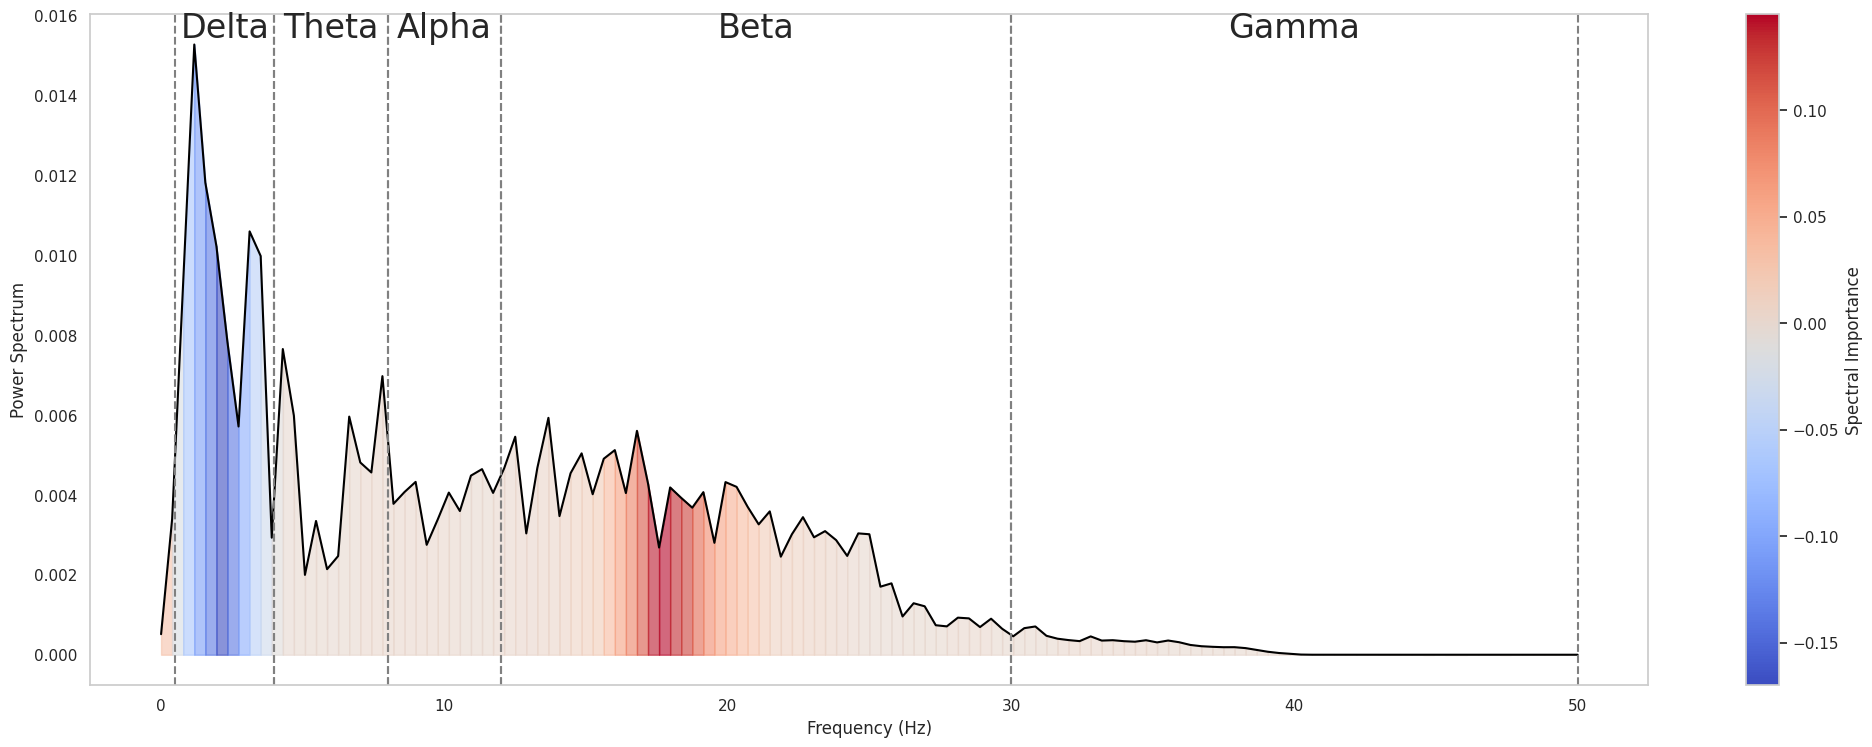

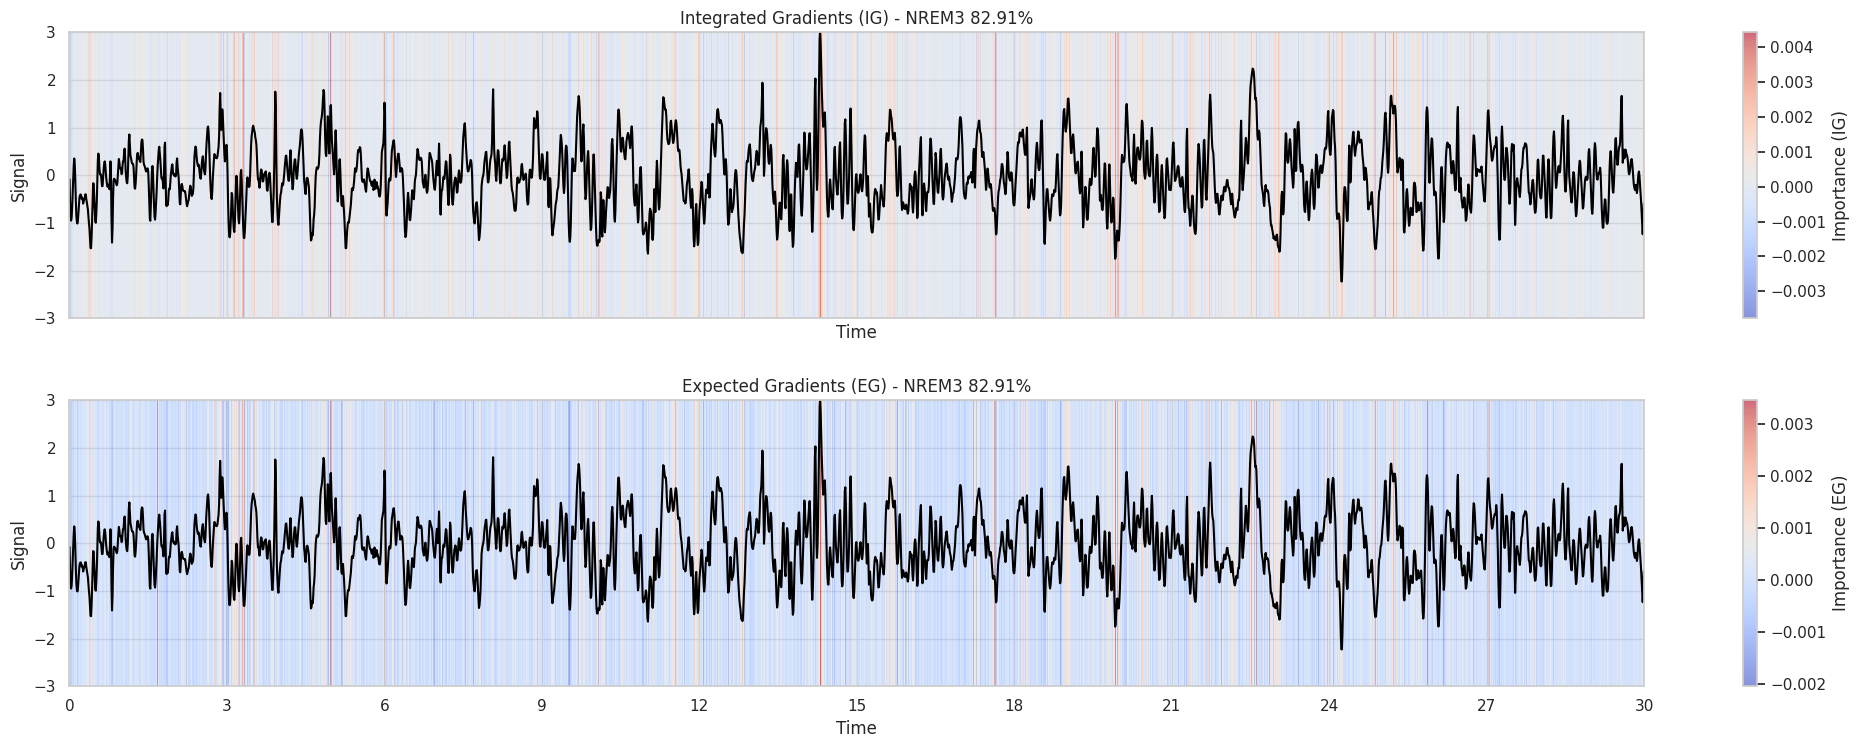

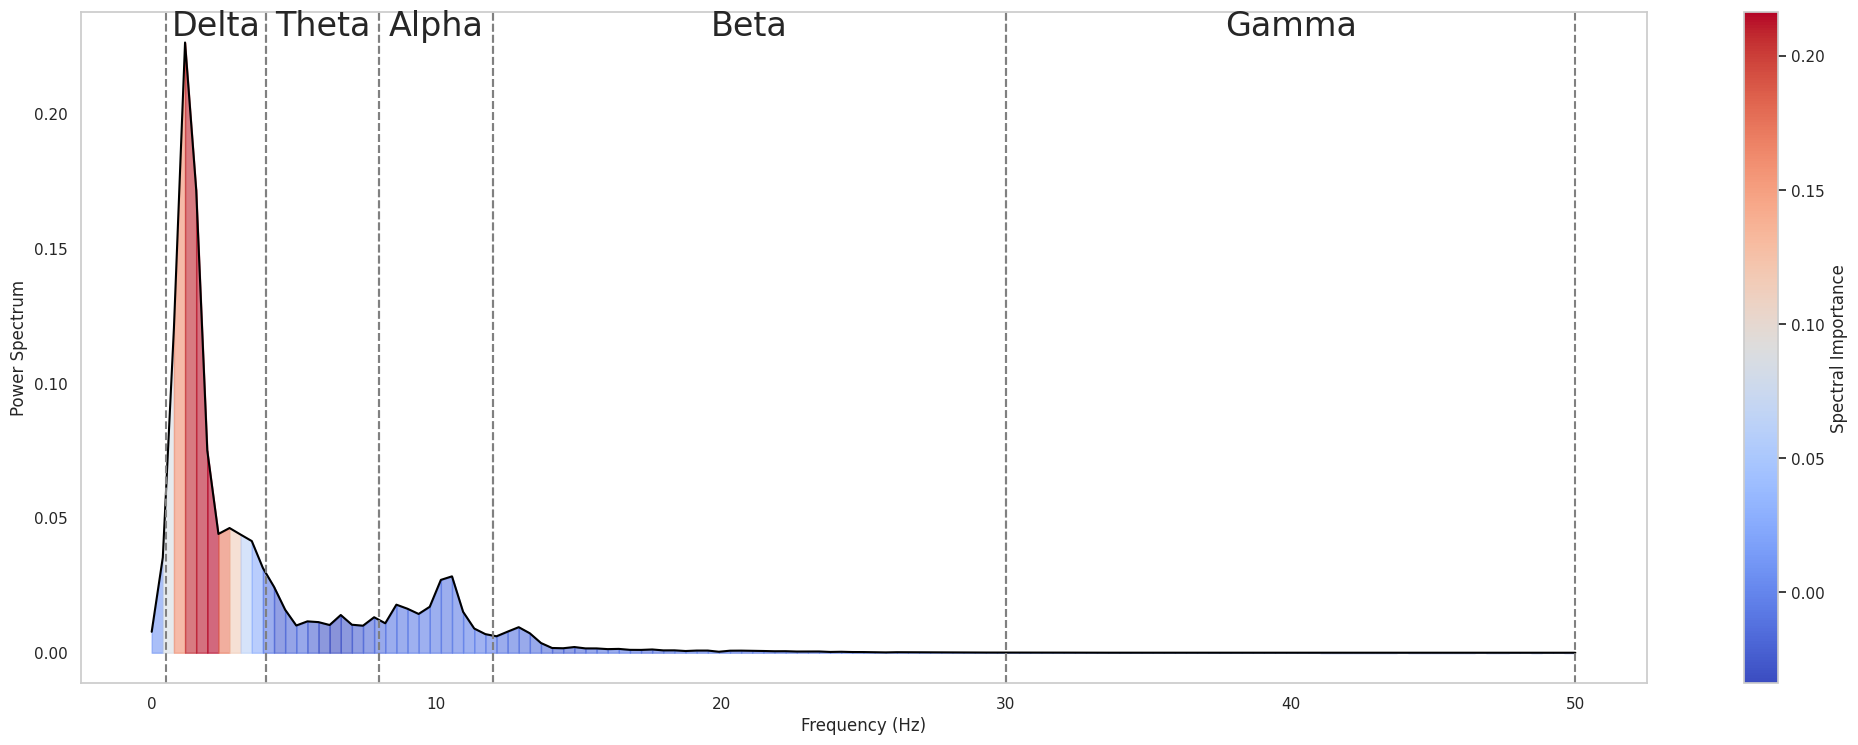

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch
from scipy.interpolate import interp1d


def plot_sg_importances(signal, SG, title_suffix):
    signal, SG= signal[10, 0, :], SG[10, 0, :]
    fs = 100  # Frequenza di campionamento

    # Supponiamo che `signal` e `SG` siano già definiti
    # signal: il segnale originale
    # SG: le importanze spettrali

    # Calcola lo spettro di potenza
    frequencies, power_spectrum = welch(signal, fs=fs)
    spectral_importances = np.sum(SG, axis=0)

    # Interpolare le importanze spettrali per adattarle alla lunghezza dello spettro di potenza
    interp_func = interp1d(np.linspace(0, fs/2, len(spectral_importances)), spectral_importances, kind='linear')
    spectral_importances_interp = interp_func(frequencies)

    # Creare una figura con un subplot
    fig, ax = plt.subplots(figsize=(21, 8))

    # Tracciare lo spettro di potenza del segnale originale
    ax.plot(frequencies, power_spectrum, color='black')

    # Aggiungere un overlay colorato per mostrare le importanze spettrali con trasparenza
    for i in range(len(frequencies) - 1):
        color = plt.cm.coolwarm((spectral_importances_interp[i] - min(spectral_importances_interp)) / (max(spectral_importances_interp) - min(spectral_importances_interp)))
        ax.fill_between(frequencies[i:i+2], power_spectrum[i:i+2], color=color, alpha=0.6)

    # Delimitare le bande del sonno con linee verticali
    sleep_bands = {
        'Delta': (0.5, 4),
        'Theta': (4, 8),
        'Alpha': (8, 12),
        'Beta': (12, 30),
        'Gamma': (30, 50)
    }

    for band, (start, end) in sleep_bands.items():
        ax.axvline(x=start, color='grey', linestyle='--')
        ax.axvline(x=end, color='grey', linestyle='--')
        ax.text((start + end) / 2, max(power_spectrum), band, horizontalalignment='center', verticalalignment='bottom')

    # Aggiungere una barra di colore per riferimento delle importanze
    sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=plt.Normalize(vmin=min(spectral_importances_interp), vmax=max(spectral_importances_interp)))
    cbar = plt.colorbar(sm, ax=ax)
    cbar.set_label('Spectral Importance')

    # Impostare le etichette degli assi
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('Power Spectrum')

    ax.grid(False)

    # Mostrare la figura
    plt.tight_layout()
    plt.savefig(f"{title_suffix}_sg.png", dpi=300)
    plt.show()
    plt.close()
    
def plot_importances(signal, IG, EG, title_suffix):
    signal, IG, EG = signal[10, 0, :], IG[10, 0, :], EG[10, 0, :]
    
    fig, ax = plt.subplots(2, 1, figsize=(21, 8), sharex="col", sharey="row")

    # Tracciare il segnale dell'epoca centrale in tutti i subplot con colore nero
    for i in range(2):
        ax[i].plot(np.arange(len(signal)), signal, color='black')

    # Aggiungere un overlay colorato per mostrare i punteggi di importanza con meno trasparenza
    # Overlay per IG Wake
    X, Y = np.meshgrid(np.arange(len(signal)), np.linspace(min(signal), max(signal), 2))
    im_ig_wake = ax[0].pcolormesh(X, Y, np.tile(IG, (2, 1)), cmap='coolwarm', alpha=0.6, shading='auto')
    ax[0].set_title(f'Integrated Gradients (IG) - {title_suffix}')

    # Overlay per EG Wake
    im_eg_wake = ax[1].pcolormesh(X, Y, np.tile(EG, (2, 1)), cmap='coolwarm', alpha=0.6, shading='auto')
    ax[1].set_title(f'Expected Gradients (EG) - {title_suffix}')

    # il segnale è 30s a 100Hz metti le etichette in secondi da 0 a 30
    ax[1].set_xticks(np.linspace(0, 3000, 11))
    ax[1].set_xticklabels(np.linspace(0, 30, 11).astype(int))
        
    # Impostare le etichette degli assi
    for a in ax:
        a.set_xlabel('Time')
        a.set_ylabel('Signal')

    # Aggiungere una barra di colore per riferimento delle importanze
    cbar_ig_wake = fig.colorbar(im_ig_wake, ax=ax[0], orientation='vertical')
    cbar_ig_wake.set_label('Importance (IG)')
    cbar_eg_wake = fig.colorbar(im_eg_wake, ax=ax[1], orientation='vertical')
    cbar_eg_wake.set_label('Importance (EG)')
    
    # Impostare i limiti degli assi y
    for a in ax:
        a.set_ylim(-3, 3)

    # aumenta il font size di tutta la figura
    plt.rcParams.update({'font.size': 24})
    
    # Mostrare la figura
    plt.tight_layout()
    # salva il plot in alta qualità
    plt.savefig(f"{title_suffix}_ig.png", dpi=300)

    plt.show()    
    plt.close()

# Supponendo che `wake_importances` e `nrem3_importances` siano già definiti
wake_ig, wake_eg, wake_sg = wake_importances
nrem3_ig, nrem3_eg, nrem3_sg = nrem3_importances

# Supponendo che `signal` sia già definito
index = 1
#while index < len(wake_ig):
probas_string = [ f"{prob.item():.2f}%" for prob in wake_probas[index]*100 ]
probas_string = probas_string[0]

plot_importances(wake[index], wake_ig[index], wake_eg[index], f"Wake {probas_string}")

plot_sg_importances(wake[index], wake_sg[index], "Wake")

index = 3
probas_string = [ f"{prob:.2f}%" for prob in nrem3_probas[index]*100 ]
probas_string = probas_string[3]

plot_importances(nrem3[index], nrem3_ig[index], nrem3_eg[index], f"NREM3 {probas_string}")

plot_sg_importances(nrem3[index], nrem3_sg[index], "NREM3")
    
#    key = input("Press 'space' to continue or 'enter' to exit: ")
#    if key == ' ':
#        index += 1
#    else:
#        break

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch
from scipy.interpolate import interp1d


def plot_sg_importances(signal, SG):
    fs = 100  # Frequenza di campionamento

    # Supponiamo che `signal` e `SG` siano già definiti
    # signal: il segnale originale
    # SG: le importanze spettrali

    # Calcola lo spettro di potenza
    frequencies, power_spectrum = welch(signal, fs=fs)
    spectral_importances = np.sum(SG, axis=0)

    # Interpolare le importanze spettrali per adattarle alla lunghezza dello spettro di potenza
    interp_func = interp1d(np.linspace(0, fs/2, len(spectral_importances)), spectral_importances, kind='linear')
    spectral_importances_interp = interp_func(frequencies)

    # Creare una figura con un subplot
    fig, ax = plt.subplots(figsize=(10, 5))

    # Tracciare lo spettro di potenza del segnale originale
    ax.plot(frequencies, power_spectrum, color='black')

    # Aggiungere un overlay colorato per mostrare le importanze spettrali con trasparenza
    for i in range(len(frequencies) - 1):
        color = plt.cm.coolwarm((spectral_importances_interp[i] - min(spectral_importances_interp)) / (max(spectral_importances_interp) - min(spectral_importances_interp)))
        ax.fill_between(frequencies[i:i+2], power_spectrum[i:i+2], color=color, alpha=0.6)

    # Delimitare le bande del sonno con linee verticali
    sleep_bands = {
        'Delta': (0.5, 4),
        'Theta': (4, 8),
        'Alpha': (8, 12),
        'Beta': (12, 30),
        'Gamma': (30, 50)
    }

    for band, (start, end) in sleep_bands.items():
        ax.axvline(x=start, color='grey', linestyle='--')
        ax.axvline(x=end, color='grey', linestyle='--')
        ax.text((start + end) / 2, max(power_spectrum), band, horizontalalignment='center', verticalalignment='bottom')

    # Aggiungere una barra di colore per riferimento delle importanze
    sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=plt.Normalize(vmin=min(spectral_importances_interp), vmax=max(spectral_importances_interp)))
    cbar = plt.colorbar(sm, ax=ax)
    cbar.set_label('Spectral Importance')

    # Impostare le etichette degli assi
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('Power Spectrum')

    ax.grid(False)

    # Mostrare la figura
    plt.tight_layout()
    plt.show()
    plt.close()
    

In [72]:
print(frequencies)

[ 0.        0.390625  0.78125   1.171875  1.5625    1.953125  2.34375
  2.734375  3.125     3.515625  3.90625   4.296875  4.6875    5.078125
  5.46875   5.859375  6.25      6.640625  7.03125   7.421875  7.8125
  8.203125  8.59375   8.984375  9.375     9.765625 10.15625  10.546875
 10.9375   11.328125 11.71875  12.109375 12.5      12.890625 13.28125
 13.671875 14.0625   14.453125 14.84375  15.234375 15.625    16.015625
 16.40625  16.796875 17.1875   17.578125 17.96875  18.359375 18.75
 19.140625 19.53125  19.921875 20.3125   20.703125 21.09375  21.484375
 21.875    22.265625 22.65625  23.046875 23.4375   23.828125 24.21875
 24.609375 25.       25.390625 25.78125  26.171875 26.5625   26.953125
 27.34375  27.734375 28.125    28.515625 28.90625  29.296875 29.6875
 30.078125 30.46875  30.859375 31.25     31.640625 32.03125  32.421875
 32.8125   33.203125 33.59375  33.984375 34.375    34.765625 35.15625
 35.546875 35.9375   36.328125 36.71875  37.109375 37.5      37.890625
 38.28125  38.6718

In [55]:
print( spectral_importances )
print( n_bands )
print( len(bands))
print( bands )

print( len( power_spectrum))
print( frequencies )

[-0.00142455 -0.00253317  0.00179305 -0.00262322  0.00130662  0.00013161
  0.00122448  0.02293665  0.0727952   0.10086922  0.07989929  0.07419574
 -0.0734705  -0.09560712  0.02319158  0.06344461 -0.04378607 -0.06696263
  0.00015215  0.01762703]
50
50
[[0.0001, 0.98], [0.98, 1.96], [1.96, 2.94], [2.94, 3.92], [3.92, 4.9], [4.9, 5.88], [5.88, 6.86], [6.86, 7.84], [7.84, 8.82], [8.82, 9.8], [9.8, 10.78], [10.78, 11.76], [11.76, 12.74], [12.74, 13.72], [13.72, 14.7], [14.7, 15.68], [15.68, 16.66], [16.66, 17.64], [17.64, 18.62], [18.62, 19.6], [19.6, 20.58], [20.58, 21.56], [21.56, 22.54], [22.54, 23.52], [23.52, 24.5], [24.5, 25.48], [25.48, 26.46], [26.46, 27.44], [27.44, 28.42], [28.42, 29.4], [29.4, 30.38], [30.38, 31.36], [31.36, 32.34], [32.34, 33.32], [33.32, 34.3], [34.3, 35.28], [35.28, 36.26], [36.26, 37.24], [37.24, 38.22], [38.22, 39.2], [39.2, 40.18], [40.18, 41.16], [41.16, 42.14], [42.14, 43.12], [43.12, 44.1], [44.1, 45.08], [45.08, 46.06], [46.06, 47.04], [47.04, 48.02], [

In [18]:
def smooth_importance(heatmap, n=3):
    heatmap = heatmap.copy()

    for i in range(heatmap.shape[0]):  # 20

        # start 0, end -n, step n
        for j in range(0, heatmap.shape[1] - n, n):
            # take the sign of the maximum abs value in the window
            # max_index = np.argmax(np.abs(heatmap[i, j : j + n]))
            # max_value = heatmap[i, j : j + n][max_index]

            heatmap[i, j : j + n] = np.ones(n) * heatmap[i, j : j + n].sum()

    return heatmap

In [39]:
# consider the first element of X, compute the importances for both models
id = 0
x = X[id].unsqueeze(0)
chambon_target = torch.argmax(y_chambon, dim=1)[id]
tiny_target = torch.argmax(y_tiny, dim=1)[id]

print(f"Predicted class by chambonnet: {chambon_target}")
print(f"Predicted class by tinysleepnet: {tiny_target}")

print(f"Chambon probabilities {y_chambon[id]}")
print(f"Tiny probabilities {y_tiny[id]}")

with torch.no_grad():
    chambon_attr = (
        chambon_sg.attribute(x.to(device), target=tiny_target).detach().cpu().numpy()
    )
    tiny_attr = (
        tiny_sg.attribute(x.to(device), target=tiny_target).detach().cpu().numpy()
    )

    chambon_ig_attr = (
        chambon_ig.attribute(x.to(device), target=tiny_target).detach().cpu().numpy()
    )
    tiny_ig_attr = (
        tiny_ig.attribute(x.to(device), target=tiny_target).detach().cpu().numpy()
    )


chambon_attr = np.transpose(np.squeeze(chambon_attr), (0, 2, 1))
tiny_attr = np.transpose(np.squeeze(tiny_attr), (0, 2, 1))

chambon_ig_attr = np.squeeze(chambon_ig_attr)
tiny_ig_attr = np.squeeze(tiny_ig_attr)

print(chambon_attr.shape, tiny_attr.shape, chambon_ig_attr.shape, tiny_ig_attr.shape)

Predicted class by chambonnet: 3
Chambon probabilities tensor([1.4609e-03, 1.7652e-04, 3.9065e-01, 6.0762e-01, 9.2635e-05])
Tiny probabilities tensor([5.6513e-03, 3.4769e-04, 6.9417e-01, 2.9926e-01, 5.7095e-04])
(21, 20, 3000) (21, 20, 3000) (21, 3000) (21, 3000)


In [40]:
# compute the approximation error

chambon_err = np.linalg.norm(chambon_ig_attr - chambon_attr.sum(axis=1))
tiny_err = np.linalg.norm(tiny_ig_attr - tiny_attr.sum(axis=1))

print(f"Chambon error {chambon_err}")
print(f"Tiny error {tiny_err}")

print(chambon_attr.shape)

Chambon error 0.24356527920298668
Tiny error 0.14501848663468164
(21, 20, 3000)


Frequency bands: [[0.09999999999999999, 0.1363043775957031], [0.1363043775957031, 0.18578883351752018], [0.18578883351752018, 0.253238313168373], [0.253238313168373, 0.34517490659800826], [0.34517490659800826, 0.4704885080549647], [0.4704885080549647, 0.6412964325636293], [0.6412964325636293, 0.874115110949303], [0.874115110949303, 1.1914571614494371], [1.1914571614494371, 1.624008268233087], [1.624008268233087, 2.213594362117866], [2.213594362117866, 3.0172260177783334], [3.0172260177783334, 4.112611144188375], [4.112611144188375, 5.605669023017489], [5.605669023017489, 7.640772271899125], [7.640772271899125, 10.41470708871716], [10.41470708871716, 14.195701675691504], [14.195701675691504, 19.349362814394112], [19.349362814394112, 26.374028552894305], [26.374028552894305, 35.948955465935626], [35.948955465935626, 49.0]]
torch.Size([1, 21, 1, 3000])


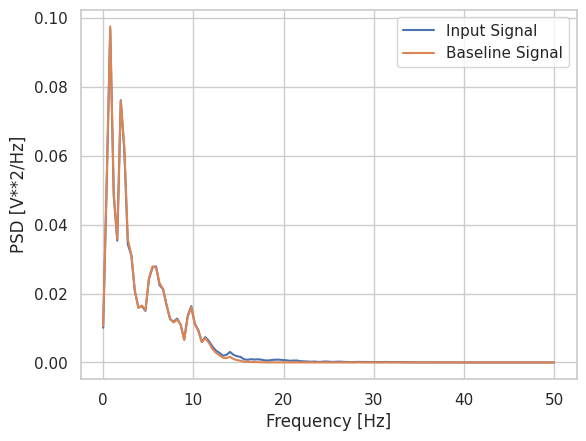

In [41]:
from scipy.signal import welch
import matplotlib.pyplot as plt

baseline = SpectralGradients(chambon, n_bands=20, mode="log")._construct_baseline(x)

# b è il tuo segnale
b = baseline[0, 0, 0, :, 16].numpy()
print(x.shape)
# Calcola lo spettro di potenza
frequencies, power_spectrum = welch(x[0, 0, 0], fs=100)

# Traccia lo spettro di potenza
sns.lineplot(x=frequencies, y=power_spectrum, label="Input Signal")

frequencies, power_spectrum = welch(b, fs=100)
sns.lineplot(x=frequencies, y=power_spectrum, label="Baseline Signal")

plt.xlabel("Frequency [Hz]")
plt.ylabel("PSD [V**2/Hz]")
plt.legend()
plt.show()

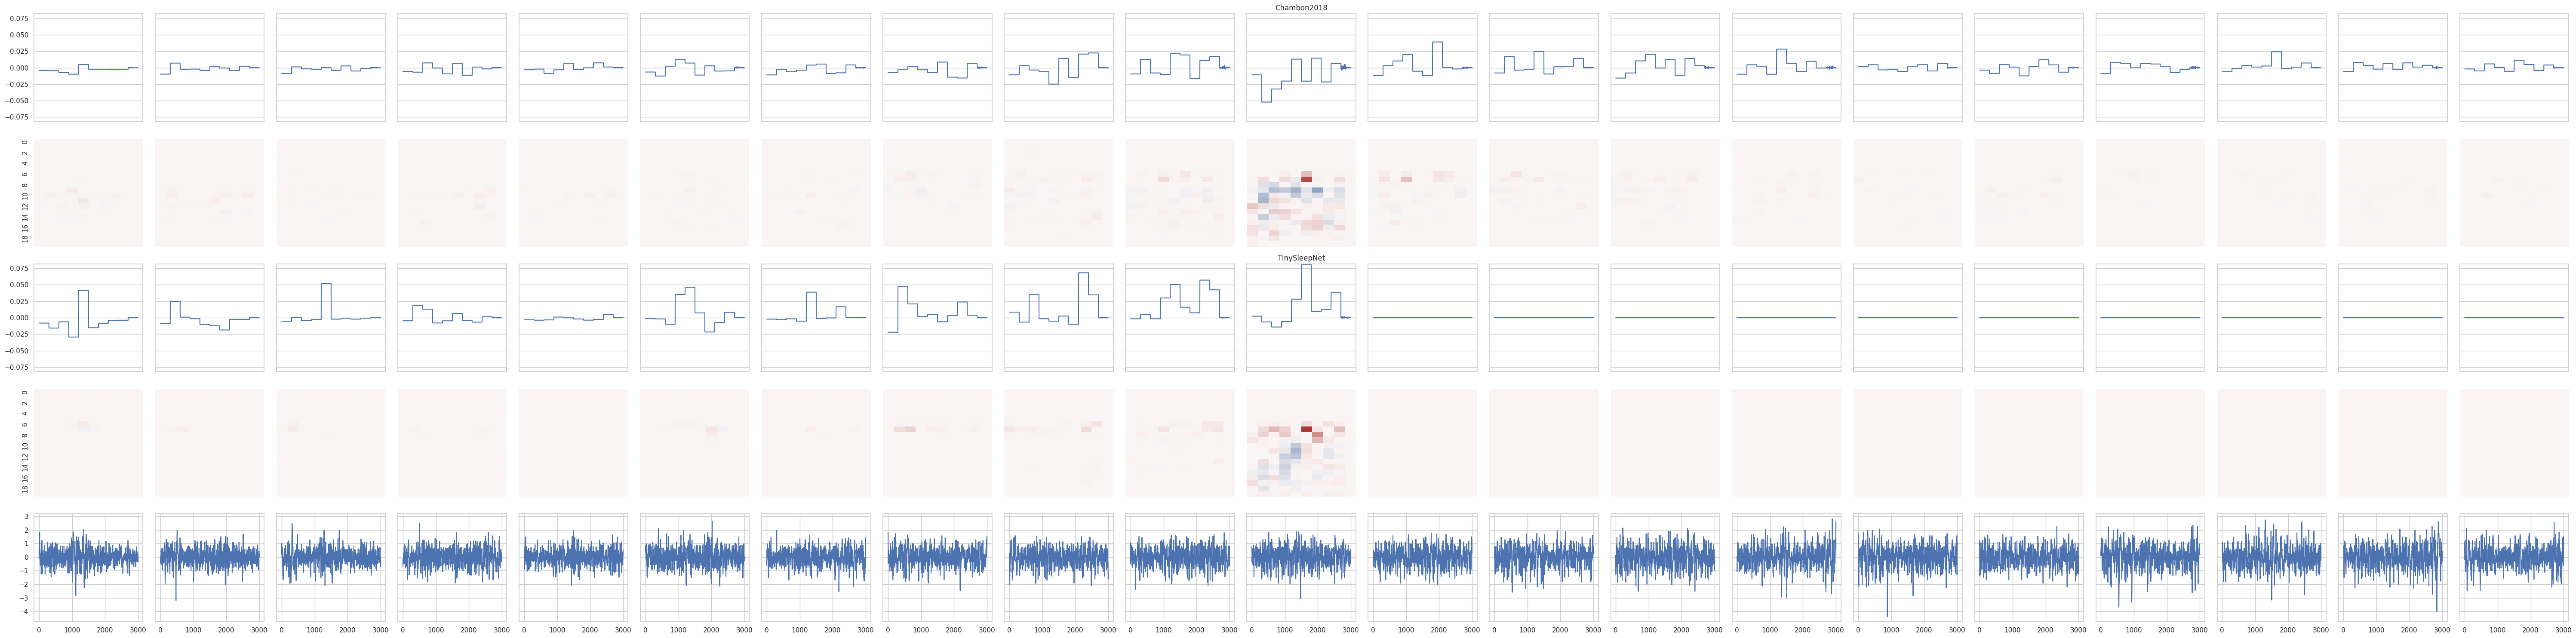

In [42]:
# plot the spectral and ig importances and the input signal for both models

fig, ax = plt.subplots(
    nrows=5,
    ncols=sequence_length,
    figsize=(60, 15),
    sharey="row",
    # height_ratios=[1/n_bands, 1, 1/n_bands, 1, 1]
)

# plot the input signal in the last row

chambon_plot = [
    smooth_importance(chambon_attr[i], n=300) for i in range(sequence_length)
]
tiny_plot = [smooth_importance(tiny_attr[i], n=300) for i in range(sequence_length)]

tiny_plot = np.array(tiny_plot)
chambon_plot = np.array(chambon_plot)

chambon_ig_plot = np.array(
    [
        smooth_importance(np.expand_dims(chambon_ig_attr[i], axis=0), n=300)
        for i in range(sequence_length)
    ]
)
tiny_ig_plot = np.array(
    [
        smooth_importance(np.expand_dims(tiny_ig_attr[i], axis=0), n=300)
        for i in range(sequence_length)
    ]
)

vmax = np.max(
    [
        np.max(tiny_plot),
        np.max(chambon_plot),
        np.max(chambon_ig_plot),
        np.max(tiny_ig_plot),
    ]
)
vmin = -vmax

for i in range(sequence_length):

    sns.lineplot(x=np.arange(x.shape[-1]), y=x[0, i, 0].numpy(), ax=ax[4, i])

    # attributions plot of chambon2018
    sns.lineplot(
        x=np.arange(x.shape[-1]),
        y=np.squeeze(chambon_ig_plot[i]),
        ax=ax[0, i],
        # cmap="vlag",
        # vmax=vmax,
        # vmin=vmin,
        # cbar=False,
    )
    ax[0, i].set_xticks([])
    ax[0, i].set_ylim(vmin, vmax)
    sns.heatmap(
        chambon_plot[i],
        ax=ax[1, i],
        cmap="vlag",
        vmax=vmax,
        vmin=vmin,
        cbar=False,
    )
    # hide xticks for the first two rows
    ax[1, i].set_xticks([])

    # attributions plot of tinysleepnet
    sns.lineplot(
        x=np.arange(x.shape[-1]),
        y=np.squeeze(tiny_ig_plot[i]),
        ax=ax[2, i],
        # cmap="vlag",
        # vmax=vmax,
        # vmin=vmin,
        # cbar=False,
    )
    ax[2, i].set_xticks([])
    ax[2, i].set_ylim(vmin, vmax)
    sns.heatmap(
        tiny_plot[i],
        ax=ax[3, i],
        cmap="vlag",
        vmax=vmax,
        vmin=vmin,
        cbar=False,
    )
    ax[3, i].set_xticks([])

# set the first two rows title as chambon2018
ax[0, int(sequence_length / 2)].set_title("Chambon2018")
ax[2, int(sequence_length / 2)].set_title("TinySleepNet")

plt.tight_layout()
plt.show()